In [4]:
pip show langchain

Name: langchain
Version: 1.0.2
Summary: Building applications with LLMs through composability
Home-page: https://docs.langchain.com/
Author: 
Author-email: 
License: MIT
Location: /opt/anaconda3/envs/finbert/lib/python3.10/site-packages
Requires: langchain-core, langgraph, pydantic
Required-by: langchain-tavily
Note: you may need to restart the kernel to use updated packages.


In [19]:
!pip install pypdf

In [13]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 44.4 MB/s eta 0:00:00


In [69]:
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.tools import tool
import yfinance as yf
import pandas as pd
import json
import os
from datetime import datetime
from typing import Literal
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import OpenAIEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from operator import itemgetter
from typing import Dict, Any, Optional
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough



from dotenv import load_dotenv
import faiss
load_dotenv()

os.environ["OPEN_AI_KEY"]=os.getenv("OPEN_AI_KEY")


## Market Analysis

In [17]:
def get_ytd_return(ticker):
    year_start = datetime(datetime.today().year, 1, 1)
    data = yf.download(ticker, start=year_start)
    if len(data) < 2:
        return None
    first_open = float(data["Open"].iloc[0])
    last_close = float(data["Close"].iloc[-1])
    ytd_return = (last_close - first_open) / first_open * 100
    return round(ytd_return, 2)

def get_latest_close(ticker):
    data = yf.Ticker(ticker).history(period="2d")
    if "Close" in data and len(data) > 0:
        # Extract scalar from possible Series using float()
        return float(data["Close"].iloc[-1])
    return None


@tool
def getMarketAnalysis() -> str:
    """
    Analyze the market data and provide insights.
    """
    # Logic to analyze market data
    results = {
        "S&P 500 YTD (%)": get_ytd_return("^GSPC"),
        "AGG ETF YTD (%)": get_ytd_return("AGG"),
        "VIX Current": get_latest_close("^VIX"),
    }
    market_results = json.dumps(results, indent=2)
    return market_results

## Portfolio Recommendaiton

In [85]:
def init_inputdata(market_json: str): 
  client_profile = {
    "age": 49,
    "gender": "Male",
    "education": "PhD",
    "marital_status": "Divorced",
    "employment": {
      "current_status": "Unemployed",
      "previous_job_tenure_years": 19
    },
    "annual_income": 72799,
    "assets": 120228,
    "debt": {
      "amount": 45713,
      "type": "Business Loan"
    },
    "credit_score": 688,
    "credit_score_label": "Fair",
    "payment_history": {
      "quality": "Poor",
      "prior_defaults": 2
    },
    "debt_to_income_ratio_percent": 15,
    "debt_to_income_ratio_comment": "manageable, but watch repayment capacity",
    "risk_rating": "Low",
    "investor_profile": "Conservative"
  }

  market_data = {
      "S&P 500 YTD (%)": 16.73,
      "AGG ETF YTD (%)": 6.92,  
      "VIX Current": 16.920000076293945 
  }
  prompt_profile = json.dumps(client_profile, indent=2)
  prompt_market = json.dumps(market_json, indent=2)
  
  return prompt_profile, prompt_market


In [86]:
FAISS_STORE = 'faiss_vector_store'
asset_documents = os.path.join('data', 'Investment Report', 'PortfolioRecommendationMorningstar.pdf')

def getapikey():
    api_key = os.getenv("OPEN_AI_KEY")
    if api_key:
        api_key = api_key.strip()
        return api_key
    return None

def format_docs(docs):
    return "\n\n".join(d.page_content for d in docs)


def build_and_store_(embeddings, doc_path):
    #check if FAISS vector store exists
    if os.path.exists(FAISS_STORE):
        print("Loading existing FAISS vector store...")
        return FAISS.load_local(
            FAISS_STORE, 
            embeddings,
            allow_dangerous_deserialization=True
        )
    
    print("Building new FAISS vector store...")
    # Load the PDF document
    loader = PyPDFLoader(doc_path)
    documents = loader.load()
    # Split the documents into smaller chunks
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    docs = text_splitter.split_documents(documents)
    #embeddings = OpenAIEmbeddings()
    vector_store = FAISS.from_documents(docs, embeddings)
    vector_store.save_local(FAISS_STORE)
    return vector_store

def generate_prompt_response(retriever, embeddings, market_json):

    # Prepare prompt data
    prompt_profile, prompt_market = init_inputdata(market_json)

    # initialize Chat model
    openai_chat_model = ChatOpenAI(model="gpt-4o-mini", temperature=0, openai_api_key=getapikey())
    
    RAG_PROMPT = """
            You are a professional financial advisor. 
            Your task is to generate a portfolio recommendation based on a client profile and current market outlook.

            ### Instructions:
            1. Always analyze the client profile (age, income, assets, debt, risk tolerance, etc.) before recommending.  
            2. Incorporate the provided market data (S&P 500, Bonds/AGG, VIX).  
            3. Follow a **clear structure** in your response:
            - Portfolio Recommendation Table (Asset Class | Target Allocation % | Example Instruments)  
            - Rationale (Explain in simple terms why each allocation is chosen, considering both client profile and market data).  
            - Compliance & Suitability Notes (Ensure recommendations align with risk profile and liquidity needs).  

            4. Keep the explanation **concise, client-friendly, and professional**.  

            ### Example Output Format

            Client Profile:  
            - Age: 45, Married, Employed, Annual Income: $90K, Assets: $150K, Debt: $25K (Mortgage), Risk Rating: Medium  
            - Market Data insights: S&P 500 +8.2% YTD, Bonds -0.5% YTD, VIX 18  

            **Portfolio Recommendation Table**  
            | Asset Class                 | Target Allocation | Example Instruments          |  
            |------------------------------|------------------|------------------------------|  
            | U.S. Bonds (Short-Maturity) | 30%              | SHY, BND                     |  
            | U.S. Equities (Large Cap)   | 40%              | SPY, VOO                     |  
            | International Equities       | 15%              | VXUS                         |  
            | Cash & Money Market         | 15%              | Money Market Fund, HYSA      |  

            **Rationale:**  
            This allocation balances stability and growth. The 30% bonds provide safety given the medium risk profile. 40% equities capture ongoing U.S. market growth (S&P +8.2%). 15% international equities add diversification. 15% cash ensures liquidity for short-term needs.  

            ### Now Apply the Same to This Case

            Client Profile:
            {prompt_profile}

            Market Data:
            {prompt_market}

            Provide the portfolio recommendation in the same structured format.
            """.strip()
    
    rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)
    retrieval_augmented_generation_chain = (
        {
            # fan-out: derive the two prompt fields
            "question": itemgetter("question"),
            "context": itemgetter("question") | retriever | format_docs,
            "prompt_profile": lambda _: prompt_profile,
            "prompt_market":  lambda _: prompt_market,
        }
        # feed them to prompt -> model -> parse to a string
        | rag_prompt
        | openai_chat_model
        | StrOutputParser()
    )

    result = retrieval_augmented_generation_chain.invoke({"question": "AI Financial advisor"})

    return result


In [ ]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small", openai_api_key=getapikey())
# Get Vector store from disk
vector_store = build_and_store_(embeddings, asset_documents)
#
retriever = vector_store.as_retriever()

Loading existing FAISS vector store...


In [ ]:
result = generate_prompt_response(retriever, embeddings)
result

"**Client Profile:**  \n- Age: 49, Male, Divorced, PhD  \n- Employment: Unemployed (previously employed for 19 years)  \n- Annual Income: $72,799  \n- Assets: $120,228  \n- Debt: $45,713 (Business Loan)  \n- Credit Score: 688 (Fair)  \n- Payment History: Poor (2 prior defaults)  \n- Debt-to-Income Ratio: 15% (manageable)  \n- Risk Rating: Low  \n- Investor Profile: Conservative  \n\n**Market Data Insights:**  \n- S&P 500 YTD: +16.73%  \n- AGG ETF YTD: +6.92%  \n- VIX: 16.92  \n\n**Portfolio Recommendation Table**  \n| Asset Class                 | Target Allocation | Example Instruments          |  \n|------------------------------|------------------|------------------------------|  \n| U.S. Bonds (Intermediate)   | 50%              | AGG, BND                     |  \n| U.S. Equities (Large Cap)   | 20%              | SPY, VOO                     |  \n| Cash & Money Market         | 20%              | Money Market Fund, HYSA      |  \n| Alternative Investments       | 10%              

In [87]:
@tool
def getInvestmentRecommendations(risk_rating, market_analysis):
    """
    Generate investment recommendations based on risk rating and market analysis.
    """
    print(f"[DEBUG] market_analysis={market_analysis}")
    # Logic to generate investment recommendations
    investment_advise = generate_prompt_response(
        retriever = retriever, 
        embeddings = embeddings,
        market_json = market_analysis
    )
    return investment_advise

## Agentic AI

In [88]:
class AgentState(MessagesState):
    market: Optional[Dict[str, Any]] = None

#### Agent Nodes

In [89]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0, openai_api_key=getapikey())

#tool_node = ToolNode([getMarketAnalysis, getInvestmentRecommendations])


def market_agent(state: AgentState):
    sys = SystemMessage(content=(
        "You are a market analyst. Call getMarketAnalysis. "
        "Do not answer with prose; only call the tool."
    ))
    resp = llm.bind_tools([getMarketAnalysis]).invoke([sys] + state["messages"])
    return {"messages": [resp]}

def allocation_agent(state: AgentState):
    market_json = json.dumps(state.get("market", {}), indent=2)
    #risk = state.get("risk_rating") or "Low"

    sys = SystemMessage(content=(
        "You are an investment strategist. Use the stored market JSON "
        "getInvestmentRecommendations(market_analysis=...). "
        "Do not answer with prose; only call the tool."
    ))
    helper = HumanMessage(content=f"market_analysis:\n{market_json}")
    planner = llm.bind_tools([getInvestmentRecommendations])
    resp = planner.invoke([sys] + state["messages"] + [helper])
    return {"messages": [resp]}


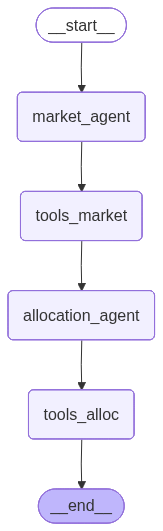

In [90]:
# tool nodes bound to specific tools
tools_market = ToolNode([getMarketAnalysis])
tools_alloc  = ToolNode([getInvestmentRecommendations])

# Build graph (NODES FIRST, then EDGES)
graph = StateGraph(AgentState)

graph.add_node("market_agent", market_agent)
graph.add_node("allocation_agent", allocation_agent)
graph.add_node("tools_market", tools_market)
graph.add_node("tools_alloc", tools_alloc)

# Edges 
graph.add_edge(START, "market_agent")
graph.add_edge("market_agent", "tools_market")        # only market tool runs here
graph.add_edge("tools_market", "allocation_agent")
graph.add_edge("allocation_agent", "tools_alloc")     # only allocation tool runs here
graph.add_edge("tools_alloc", END)

agent = graph.compile()
agent

In [91]:
if __name__ == "__main__":
    init_state = {
        "messages": [HumanMessage(content=
            "Analyze market first, then recommend an allocation for a low-risk client."
        )]
    }
    for step in agent.stream(init_state, stream_mode="values"):
        msg = step["messages"][-1]
        try:
            msg.pretty_print()
        except Exception:
            print(msg)

================================ Human Message =================================

Analyze market first, then recommend an allocation for a low-risk client.


/var/folders/0_/skr2d259613gs33jbnv_ytn80000gn/T/ipykernel_78134/2587265592.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=year_start)
[*********************100%***********************]  1 of 1 completed

================================== Ai Message ==================================
Tool Calls:
  getMarketAnalysis (call_B3wQvvCPrbUW3VCuBgPdC4PF)
 Call ID: call_B3wQvvCPrbUW3VCuBgPdC4PF
  Args:



/var/folders/0_/skr2d259613gs33jbnv_ytn80000gn/T/ipykernel_78134/2587265592.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  first_open = float(data["Open"].iloc[0])
/var/folders/0_/skr2d259613gs33jbnv_ytn80000gn/T/ipykernel_78134/2587265592.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_close = float(data["Close"].iloc[-1])
/var/folders/0_/skr2d259613gs33jbnv_ytn80000gn/T/ipykernel_78134/2587265592.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=year_start)
[*********************100%***********************]  1 of 1 completed
/var/folders/0_/skr2d259613gs33jbnv_ytn80000gn/T/ipykernel_78134/2587265592.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the

================================= Tool Message =================================
Name: getMarketAnalysis

{
  "S&P 500 YTD (%)": 15.57,
  "AGG ETF YTD (%)": 6.72,
  "VIX Current": 16.90999984741211
}
================================== Ai Message ==================================
Tool Calls:
  getInvestmentRecommendations (call_tKMkg3nkEfhihlDLNvPtsBdo)
 Call ID: call_tKMkg3nkEfhihlDLNvPtsBdo
  Args:
    risk_rating: low
    market_analysis: {'S&P 500 YTD (%)': 15.57, 'AGG ETF YTD (%)': 6.72, 'VIX Current': 16.90999984741211}
[DEBUG] market_analysis={'S&P 500 YTD (%)': 15.57, 'AGG ETF YTD (%)': 6.72, 'VIX Current': 16.90999984741211}
================================= Tool Message =================================
Name: getInvestmentRecommendations

**Client Profile:**  
- Age: 49, Male, Divorced, Education: PhD, Employment: Unemployed (previously employed for 19 years), Annual Income: $72,799, Assets: $120,228, Debt: $45,713 (Business Loan), Credit Score: 688 (Fair), Payment History: P

In [ ]:

# Define tool methods
@tool
def getRiskRating(user_profile):
    """
    Determine the risk rating based on the user's profile.
    """
    # Logic to determine risk rating based on user profile
    return "Moderate Risk" 


@tool
def getRegulatoryComplianceCheck(recommendations):
    """
    Check if the investment recommendations comply with regulations.
    """
    # Logic to check regulatory compliance
    return True

@tool
def getEducationalContent(user_profile):
    """
    Provide educational content based on the user's profile.
    """
    # Logic to provide educational content
    return ["Basics of stock market", "Understanding risk and return"]
